# Part 1: Imports, data uploads and preparation.

As is customary, let us first call the Python libraries needed here, and upload the needed data and code.

In [1]:
from model import setup, balance_calcs, visuals, performance #, func_FDC, visuals, performance
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import datetime

## Loading model and water balance for historical data

In this tutorial we will compute performance, then compare it for the scenarios defined in Tutorial 3. First let's compute the historical water balance.

In [2]:
# Preparing the model
reservoir_name = 'Conowingo'
downstream_demand_names = ['Environmental']
direct_demand_names = ['Baltimore', 'Chester', 'Nuclear plant']

# Loading the model!
conowingo = setup.define_reservoir(reservoir_name, downstream_demand_names, direct_demand_names)

# Read flow and demand data. We keep this copy of the data for the simulation of different futures.
flows_default = setup.extract_flows(reservoir=conowingo)
display(flows_default)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s)
Date,,,,,
1932-01-01,557.049006,13.139017,1.472476,0.622971,99.108963
1932-01-02,638.488257,13.139017,1.472476,0.622971,99.108963
1932-01-03,758.806538,13.139017,1.472476,0.622971,99.108963
1932-01-04,824.048553,13.139017,1.472476,0.622971,99.108963
1932-01-05,780.383975,13.139017,1.472476,0.622971,99.108963
...,...,...,...,...,...
2001-12-27,775.966547,13.139017,1.444159,0.651287,99.108963
2001-12-28,716.529486,13.139017,1.444159,0.651287,99.108963
2001-12-29,668.362530,13.139017,1.444159,0.651287,99.108963


In [3]:
# First, make a copy of the flows to initialise the water balance
sop_balance = flows_default.copy()  # Keep flows_default as an untouched copy

# Computing the water balance for our standard operating policy (SOP)
balance_calcs.sop_full(reservoir=conowingo, water_flows=sop_balance)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1932-01-01,557.049006,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,101.999728,380000000.0
1932-01-02,638.488257,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,623.253793,380000000.0
1932-01-03,758.806538,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,743.572075,380000000.0
1932-01-04,824.048553,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,808.814089,380000000.0
1932-01-05,780.383975,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,765.149512,380000000.0
...,...,...,...,...,...,...,...,...,...,...
2001-12-27,775.966547,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,760.732084,380000000.0
2001-12-28,716.529486,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,701.295023,380000000.0
2001-12-29,668.362530,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,653.128067,380000000.0


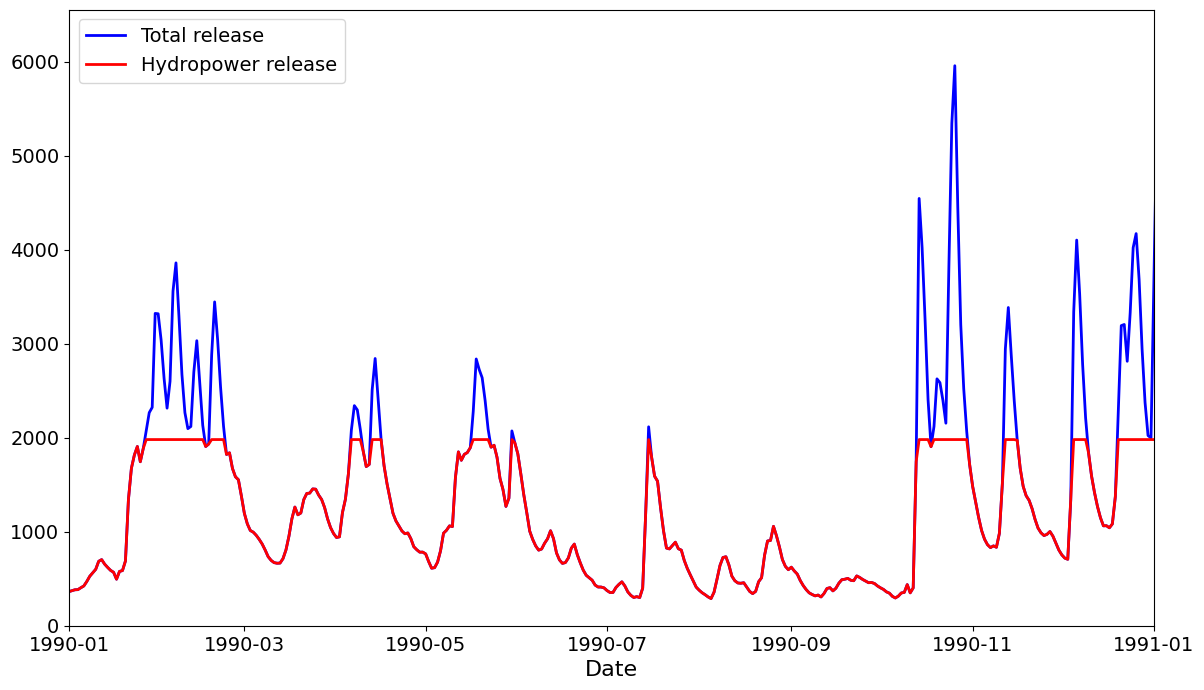

In [4]:
# Let us create a time series of hydropower releases
sop_hp_release = np.minimum(sop_balance['Release (m3/s)'].values, np.ones(len(sop_balance))*conowingo.hydropower_plant.max_release)

# We plot hydropower releases vs. total releases. What do we see?
fig = visuals.compare_flow_timeseries(reference=pd.Series(sop_balance['Release (m3/s)']),
                                      alternative=pd.Series(sop_hp_release, index=sop_balance.index),
                                      labels=['Total release', 'Hydropower release'], 
                                      first_date=datetime.date(1990, 1, 1), 
                                      last_date=datetime.date(1991, 1, 1))

**Question 1. What is the extra release? What does that mean for hydropower production?**

# Part 2: Optimizing hydropower production

Now we try to maximise hydropower production. Let us write a dynamic program to achieve this!

For this we need some building blocks. First, let's have a function that calculates value of a (release) decision that leads to a future (storage) state, below.

In [5]:
def ddp_value(immediate_value, future_state, future_value, mesh):
    """
    Value calculation for a decision under dynamic programming, general formula
    :param immediate_value: float, the immediate value of the decision
    :param future_state: float, the future state of the system as a consequence of the decision
    :param future_value: vector of future values for discretised state values
    :param mesh: vector of corresponding discretised state values
    :return: total value of the decision
    """

    # Record discrete future states where future values are of interest for our decision
    mesh_step = mesh[1] - mesh[0]
    locator = mesh[mesh > future_state - mesh_step][mesh < future_state + mesh_step].index.to_numpy()

    # The future state is one of the discretised states (almost never)
    if len(locator) == 1:
        value = immediate_value + future_value[locator[0]]

    # The future state is between two discretised states (almost always)
    if len(locator) == 2:
        weight = (future_state - mesh[locator[0]]) / (mesh[locator[1]] - mesh[locator[0]])
        value = immediate_value + weight * future_value[locator[1]] + (1-weight) * future_value[locator[0]]

    # If rounding errors lead to three values
    if len(locator) == 3:
        value = immediate_value + future_value[locator[1]]

    return value

In [6]:
def decision_taking(current_value, future_value, state_min, state_max, mesh, we_minimise, nb_decisions):
    """
    Finds the best decision for dynamic programming, from a discrete set of decisions to evaluate
    :param current_value: vector, current value of each decision
    :param future_value: vector of future values for discretised state values
    :param state_min: float, minimal possible future state resulting from decision
    :param state_max: float, maximal possible future state resulting from decision
    :param mesh: vector of corresponding discretised state values
    :param we_minimise: Boolean, True if minimization problem, False if maximization
    :param nb_decisions: int, number of decisions considered
    :return:
    """

    # Initialise vector of values for each possible decision
    value = np.zeros(nb_decisions)

    # Loop on discretised decisions
    for n in range(nb_decisions):
        # Find future state resulting from decision
        state = state_min + n / (nb_decisions - 1) * (state_max - state_min)
        # Find corresponding value
        value[n] = ddp_value(current_value[n], state, future_value, mesh)

    if we_minimise is True:
        # Best decision minimises value
        best_value = np.min(value)
        decision = np.argmin(value)
    else:
        # Best decision maximises value
        best_value = np.max(value)
        decision = np.argmax(value)

    return decision, best_value

In [7]:
def ddp_hp_backward(reservoir, water_flows, first_year, nb_states, nb_decisions):

    # Parameters
    n_sec = 86400  # Number of seconds in a day (the time step)

    # Discretisation on whole storage range
    storage_mesh = pd.Series(reservoir.dead_storage + np.arange(0, nb_states) / (nb_states - 1) *
                             (reservoir.full_lake_volume - reservoir.dead_storage))

    # Initialise water balance
    time_mask = (water_flows.index.year >= first_year) & (water_flows.index.year < first_year + 2)
    h2o_balance = water_flows.iloc[time_mask, :].copy()
    total_local_demands = balance_calcs.local_demand_init(reservoir, h2o_balance, n_sec)
    total_downstream_demands = balance_calcs.downstream_demand_init(reservoir, h2o_balance, n_sec)

    # Score table
    power_table = np.zeros((len(h2o_balance) + 1, nb_states))

    # Release table
    release_table = np.zeros((len(h2o_balance), nb_states))

    # Backward loop
    for t in np.arange(len(h2o_balance)-1, -1, -1):

        # At each time step, loop on states
        for s in range(nb_states):

            # Start with SOP, if there is spillage, no need to find for a solution
            wb_sop = balance_calcs.sop_single_step(reservoir, storage_mesh[s],
                                                   h2o_balance.loc[h2o_balance.index[t], 'Total inflows (m3/s)']*n_sec,
                                                   total_local_demands[t], total_downstream_demands[t])
            # result of SOP is the minimum release decision, leading to maximum storage among all decisions
            st_max = wb_sop[0]
            release_min = wb_sop[1]

            # If there is no spillage, see if increasing release can produce more hydropower
            if release_min / n_sec < reservoir.hydropower_plant.max_release:

                # Minimal end-of-step storage if release is maximal useful value for hydropower
                # (lower bound dead storage)
                st_min = max(st_max + release_min - reservoir.hydropower_plant.max_release * n_sec, 
                             reservoir.dead_storage)
                
                # Corresponding maximal considered release
                release_max = release_min + st_max - st_min

                # Vector of current values for each decision
                current_value = np.zeros(nb_decisions)
                for dec in range(nb_decisions):
                    current_release = release_max - (release_max - release_min) * dec / (nb_decisions - 1)
                    storage = st_max + release_min - current_release
                    hydraulic_head = reservoir.hydropower_plant.nominal_head - reservoir.total_lake_depth + \
                                     reservoir.get_height(storage)
                    current_value[dec] = 1000 * 9.81 * reservoir.hydropower_plant.efficiency * hydraulic_head * \
                                         current_release / n_sec * 24 / 1E6  # in MWh

                # Find best decision (storage, corresponding release, and score in MWh)
                x = decision_taking(current_value, power_table[t + 1, :], st_min, st_max, storage_mesh, False,
                                    nb_decisions)
                storage_decision = st_min + (x[0] / (nb_decisions-1)) * (st_max-st_min)
                release_table[t, s] = release_min + st_max - storage_decision  # Release decision
                power_table[t, s] = x[1]
            else:
                release_table[t, s] = release_min
                hydraulic_head = reservoir.hydropower_plant.nominal_head - reservoir.total_lake_depth + \
                                 reservoir.get_height(st_max)
                current_value = 1000 * 9.81 * reservoir.hydropower_plant.efficiency * hydraulic_head * \
                                         reservoir.hydropower_plant.max_release * 24 / 1E6  # in MWh
                power_table[t, s] = ddp_value(immediate_value=current_value, 
                                              future_state=st_max,
                                              future_value=power_table[t + 1], 
                                              mesh=storage_mesh)

    return release_table, power_table

In [8]:
def ddp_forward(reservoir, water_flows, year_beg, release_table, **kwargs):

    # Parameters
    n_sec = 86400  # Number of seconds in a day (the time step)

    # Optional arguments
    current_storage = kwargs.pop("initial_storage", reservoir.initial_storage)

    # Initialise water balance
    h2o_balance = water_flows.loc[datetime.date(year_beg, 1, 1): datetime.date(year_beg, 1, 1)
                                  + datetime.timedelta(days=len(release_table)), :].copy()
    total_local_demands = balance_calcs.local_demand_init(reservoir, water_flows, n_sec)

    # Initialise water balance outputs
    for i in range(total_local_demands.shape[1]):
        h2o_balance['Withdrawals ' + reservoir.demand_on_site[i].name + ' (m3/s)'] = np.zeros(len(h2o_balance))
    h2o_balance['Release (m3/s)'] = np.zeros(len(h2o_balance))
    h2o_balance['Storage (m3)'] = np.zeros(len(h2o_balance))

    # Discretisation on whole storage range
    nb_states = release_table.shape[1]
    storage_mesh = pd.Series(reservoir.dead_storage + np.arange(0, nb_states) / (nb_states - 1) *
                             (reservoir.full_lake_volume - reservoir.dead_storage))
    mesh_step = storage_mesh[1] - storage_mesh[0]

    # Forward loop
    for t in range(len(release_table)):

        locator = (storage_mesh[storage_mesh > current_storage - mesh_step][storage_mesh < current_storage + mesh_step].
                   index.to_numpy())

        if len(locator) == 1:
            release = release_table[t, locator[0]]

        if len(locator) == 2:
            weight = ((current_storage - storage_mesh[locator[0]]) /
                      (storage_mesh[locator[1]] - storage_mesh[locator[0]]))
            release = weight * release_table[t, locator[1]] + (1 - weight) * release_table[t, locator[0]]

        if len(locator) == 3:
            release = release_table[t, locator[1]]

        wb_sop = balance_calcs.sop_single_step(reservoir, current_storage,
                                               h2o_balance.loc[h2o_balance.index[t], 'Total inflows (m3/s)'] * n_sec,
                                               total_local_demands[t], release)

        # Record results
        h2o_balance.loc[h2o_balance.index[t], 'Storage (m3)'] = wb_sop[0]
        h2o_balance.loc[h2o_balance.index[t], 'Release (m3/s)'] = wb_sop[1] / n_sec
        for i in range(total_local_demands.shape[1]):
            h2o_balance.loc[h2o_balance.index[t], 'Withdrawals ' + reservoir.demand_on_site[i].name + ' (m3/s)'] = \
                wb_sop[2][i] / n_sec

        # Update storage
        current_storage = h2o_balance.loc[h2o_balance.index[t], 'Storage (m3)']

    return h2o_balance

In [9]:
tables = ddp_hp_backward(conowingo, flows_default, 1989, 11, 10)
hp_max_balance = ddp_forward(conowingo, flows_default, 1989, tables[0])
display(hp_max_balance)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1989-01-01,575.426640,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,138.960793,3.783944e+08
1989-01-02,554.925243,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,521.107347,3.800000e+08
1989-01-03,583.836743,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,568.602280,3.800000e+08
1989-01-04,568.913765,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,553.679301,3.800000e+08
1989-01-05,467.935890,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,452.701426,3.800000e+08
...,...,...,...,...,...,...,...,...,...,...
1990-12-28,2959.252053,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,2944.017590,3.800000e+08
1990-12-29,2389.148981,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,2373.914517,3.800000e+08
1990-12-30,2037.963449,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,2022.728986,3.800000e+08


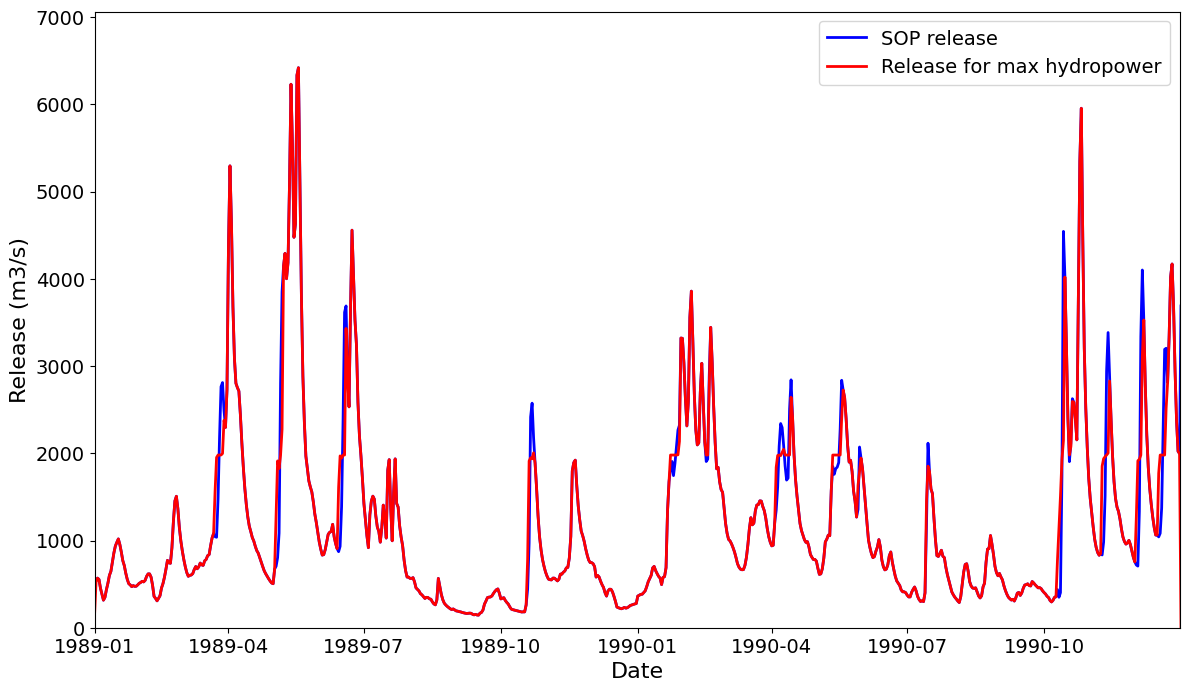

In [10]:
fig = visuals.compare_flow_timeseries(reference=pd.Series(sop_balance['Release (m3/s)']),
                                      alternative=pd.Series(hp_max_balance['Release (m3/s)']),
                                      labels=['SOP release', 'Release for max hydropower'], 
                                      first_date=datetime.date(1989, 1, 1), 
                                      last_date=datetime.date(1990, 12, 31))

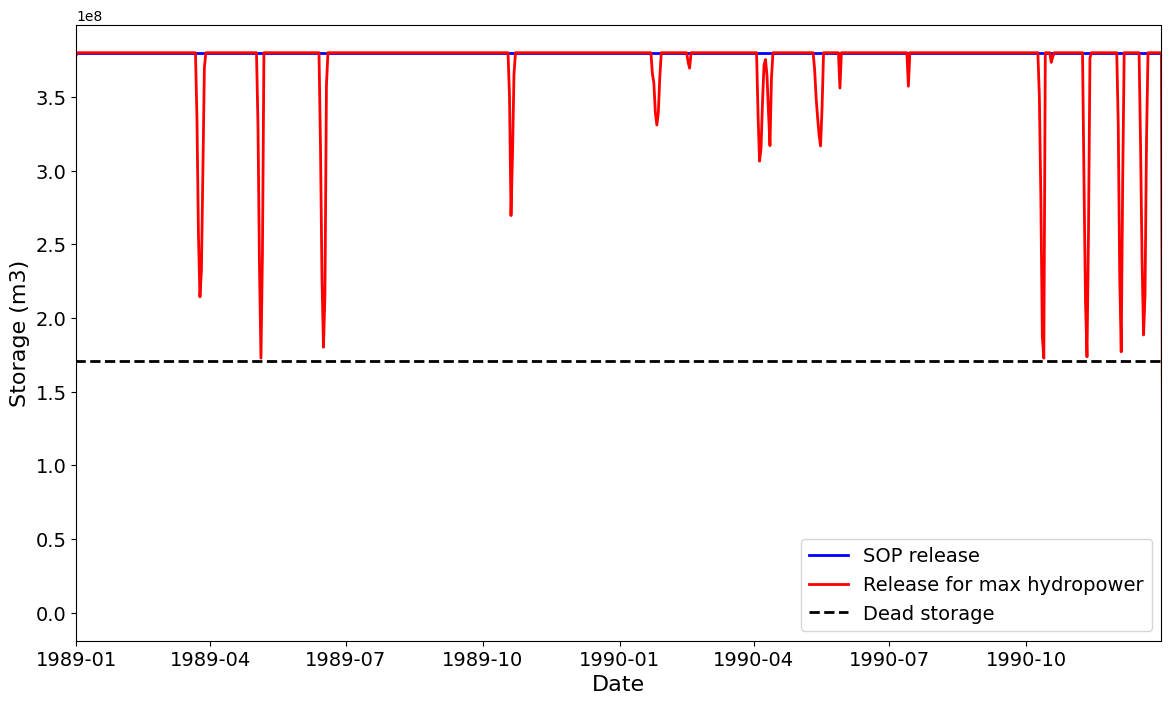

In [11]:
fig = visuals.compare_storage_timeseries(reservoir=conowingo, storage_1=pd.Series(sop_balance['Storage (m3)']),
                                      storage_2=pd.Series(hp_max_balance['Storage (m3)']),
                                      labels=['SOP release', 'Release for max hydropower'], 
                                      first_date=datetime.date(1989, 1, 1), 
                                      last_date=datetime.date(1990, 12, 31))

# Part 3: Another optimization

In [18]:
def ddp_rel_backward(reservoir, water_flows, first_year, nb_states, nb_decisions):

    # Parameters
    n_sec = 86400  # Number of seconds in a day (the time step)

    # Success condition: enough water. This corresponds to the demand with the shallowest intake being met
    shallowest_intake_depth = reservoir.total_lake_depth
    dem_nb = 0
    for d in range(len(reservoir.demand_on_site)):
        shallowest_intake_depth = min(shallowest_intake_depth, reservoir.demand_on_site[d].intake_depth)
        if shallowest_intake_depth == reservoir.demand_on_site[d].intake_depth:
            dem_nb = d

    # Associated volume
    threshold_volume = reservoir.volume_from_height(reservoir.total_lake_depth - reservoir.demand_on_site[dem_nb].intake_depth + 1)

    # Discretisation on whole storage range
    storage_mesh = pd.Series(reservoir.dead_storage + np.arange(0, nb_states) / (nb_states - 1) *
                             (reservoir.full_lake_volume - reservoir.dead_storage))

    # Initialise water balance
    time_mask = (water_flows.index.year >= first_year) & (water_flows.index.year < first_year + 2)
    h2o_balance = water_flows.iloc[time_mask, :].copy()
    total_local_demands = balance_calcs.local_demand_init(reservoir, h2o_balance, n_sec)
    total_downstream_demands = balance_calcs.downstream_demand_init(reservoir, h2o_balance, n_sec)

    # Score table
    failure_table = np.zeros((len(h2o_balance) + 1, nb_states))

    # Release table
    release_table = np.zeros((len(h2o_balance), nb_states))

    # Backward loop
    for t in np.arange(len(h2o_balance) - 1, -1, -1):

        # At each time step, loop on states
        for s in range(nb_states):

            # Start with SOP. We will only increase storage if no failure
            wb_sop = balance_calcs.sop_single_step(reservoir, storage_mesh[s],
                                                   h2o_balance.loc[h2o_balance.index[t], 'Total inflows (m3/s)']*n_sec,
                                                   total_local_demands[t], total_downstream_demands[t])
            st_max = wb_sop[0]
            release_min = wb_sop[1]

            # Check success
            # Success because enough water for all demands
            success = wb_sop[2][dem_nb] + 1E-6 > h2o_balance.loc[h2o_balance.index[t], reservoir.demand_on_site[dem_nb].name + ' demand (m3/s)'] * n_sec
            # No spillage, i.e., release smaller than max release?
            failure = 1 - int(success == True) * int(wb_sop[1] < reservoir.hydropower_plant.max_release * n_sec + 1E-6)

            # Increase release if success is true
            if failure == 0:
                # Minimal end-of-step storage if release is maximal useful value for hydropower
                # (lower bound dead storage)
                st_min = max(st_max + release_min - reservoir.hydropower_plant.max_release * n_sec, threshold_volume)
                # CORRECT THIS IT's EXTREME
                # No failure in the current state hence the current values
                current_value = np.zeros(nb_decisions)
                # Release decisions for each storage value
                x = decision_taking(current_value, failure_table[t+1], st_min, st_max, storage_mesh, True, nb_decisions)
                storage_decision = st_min + (x[0] / (nb_decisions-1)) * (st_max-st_min)
                release_table[t, s] = release_min + st_max - storage_decision  # Release decision
                failure_table[t, s] = x[1]
            else:
                # If it's a failure we don't increase release
                release_table[t, s] = wb_sop[1]
                failure_table[t, s] = ddp_value(immediate_value=failure, future_state=st_max,
                                                future_value=failure_table[t + 1], mesh=storage_mesh)

    return release_table, failure_table

In [19]:
tables_rel = ddp_rel_backward(conowingo, flows_default, 1989, 21, 10)
rel_balance = ddp_forward(conowingo, flows_default, 1989, tables_rel[0])
display(rel_balance)

,Total inflows (m3/s),Baltimore demand (m3/s),Chester demand (m3/s),Nuclear plant demand (m3/s),Environmental demand (m3/s),Withdrawals Baltimore (m3/s),Withdrawals Chester (m3/s),Withdrawals Nuclear plant (m3/s),Release (m3/s),Storage (m3)
Date,,,,,,,,,,
1989-01-01,575.426640,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,336.001063,3.613701e+08
1989-01-02,554.925243,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,539.690779,3.613701e+08
1989-01-03,583.836743,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,568.602280,3.613701e+08
1989-01-04,568.913765,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,553.679301,3.613701e+08
1989-01-05,467.935890,13.139017,1.472476,0.622971,99.108963,13.139017,1.472476,0.622971,452.701426,3.613701e+08
...,...,...,...,...,...,...,...,...,...,...
1990-12-28,2959.252053,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,2944.017590,3.800000e+08
1990-12-29,2389.148981,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,2373.914517,3.800000e+08
1990-12-30,2037.963449,13.139017,1.444159,0.651287,99.108963,13.139017,1.444159,0.651287,2022.728986,3.800000e+08


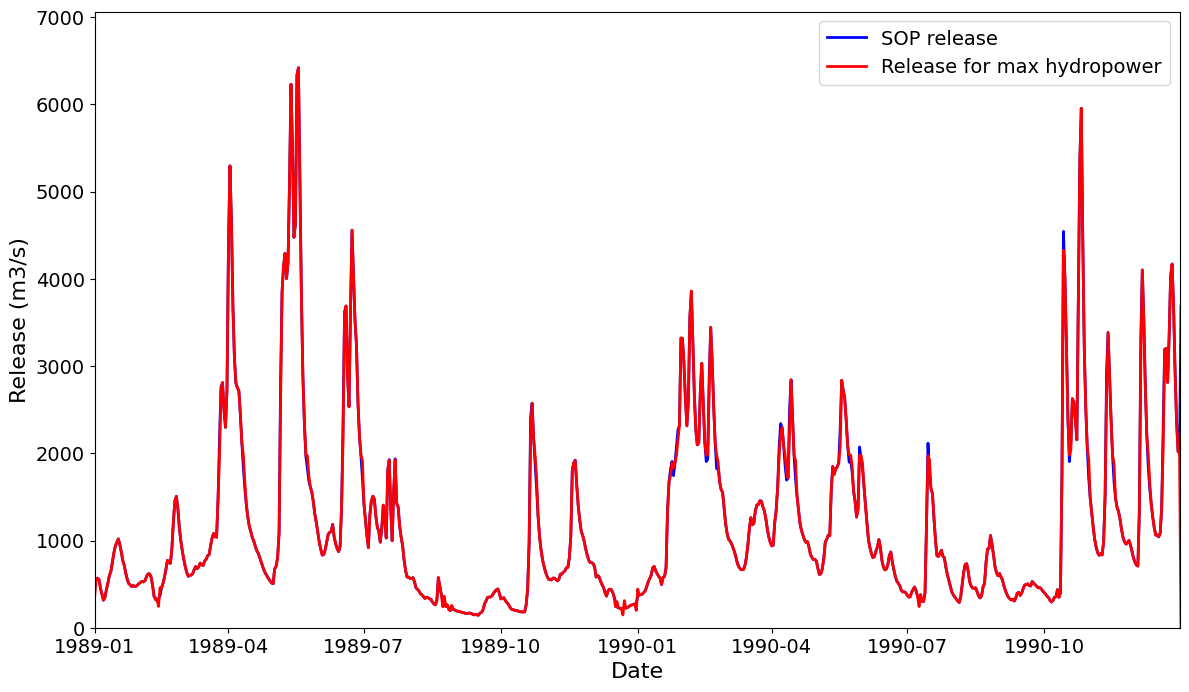

In [20]:
fig = visuals.compare_flow_timeseries(reference=pd.Series(sop_balance['Release (m3/s)']),
                                      alternative=pd.Series(rel_balance['Release (m3/s)']),
                                      labels=['SOP release', 'Release for max hydropower'], 
                                      first_date=datetime.date(1989, 1, 1), 
                                      last_date=datetime.date(1990, 12, 31))

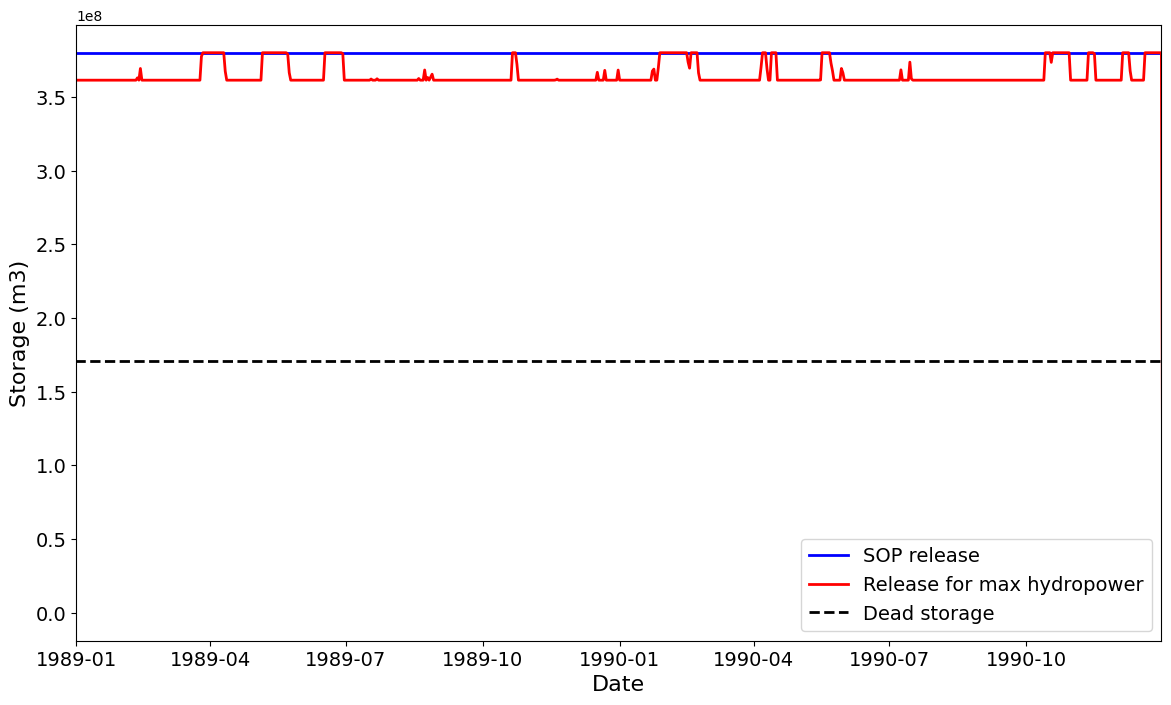

In [21]:
fig = visuals.compare_storage_timeseries(reservoir=conowingo, storage_1=pd.Series(sop_balance['Storage (m3)']),
                                      storage_2=pd.Series(rel_balance['Storage (m3)']),
                                      labels=['SOP release', 'Release for max hydropower'], 
                                      first_date=datetime.date(1989, 1, 1), 
                                      last_date=datetime.date(1990, 12, 31))

In [22]:
metrics_2 = performance.all_metrics(conowingo, rel_balance)
display(metrics_2)

C:\Users\ci1cjr\PyCharmProjects\Teaching\civx782\tutorials\model\performance.py:66: RuntimeWarning: invalid value encountered in scalar divide
  indicators.loc[0, 'Resilience (-)'] = event_count / (n_steps * (1 - indicators.loc[0, 'Reliability (0-1)']))
C:\Users\ci1cjr\anaconda3\envs\civx782\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ci1cjr\anaconda3\envs\civx782\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\ci1cjr\PyCharmProjects\Teaching\civx782\tutorials\model\setup.py:39: RuntimeWarning: invalid value encountered in divide
  return 2 * np.divide(np.minimum(self.full_lake_volume, np.maximum(0, volume)), self.get_surface_area(volume))
C:\Users\ci1cjr\PyCharmProjects\Teaching\civx782\tutorials\model\performance.py:66: RuntimeWarning: invalid value encountered in scalar divide
  i

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,0.998632,1.0,100%,1,0.998632
1,Chester,0.984952,1.0,13%,11,0.998737
2,Nuclear,0.982216,1.0,21%,13,0.998868
3,Env. flows,0.998632,1.0,100%,1,0.999004
4,Flooding,1.0,NaN,nan%,0,N/A
5,Recreation,1.0,NaN,nanm,0,N/A


In [23]:
metrics_1 = performance.all_metrics(conowingo, sop_balance.loc[datetime.date(1989, 1, 1):datetime.date(1990, 12, 31), :])
display(metrics_1)

C:\Users\ci1cjr\PyCharmProjects\Teaching\civx782\tutorials\model\performance.py:66: RuntimeWarning: invalid value encountered in scalar divide
  indicators.loc[0, 'Resilience (-)'] = event_count / (n_steps * (1 - indicators.loc[0, 'Reliability (0-1)']))
C:\Users\ci1cjr\anaconda3\envs\civx782\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ci1cjr\anaconda3\envs\civx782\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\ci1cjr\PyCharmProjects\Teaching\civx782\tutorials\model\performance.py:66: RuntimeWarning: invalid value encountered in scalar divide
  indicators.loc[0, 'Resilience (-)'] = event_count / (n_steps * (1 - indicators.loc[0, 'Reliability (0-1)']))
C:\Users\ci1cjr\anaconda3\envs\civx782\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return

,Name,Reliability (0-1),Resilience (-),Vulnerability,Failure count,Volumetric reliability
0,Baltimore,1.0,NaN,nan%,0,1.0
1,Chester,1.0,NaN,nan%,0,1.0
2,Nuclear,1.0,NaN,nan%,0,1.0
3,Env. flows,1.0,NaN,nan%,0,1.0
4,Flooding,1.0,NaN,nan%,0,N/A
5,Recreation,1.0,NaN,nanm,0,N/A
